<a href="https://colab.research.google.com/github/sagar9926/MTech_Atificial_Intelligence/blob/main/ML1/Fractal3_Assignment/Copy_Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the libraries
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn


import torch.nn.functional as F
import torch.optim as optim
import math
import albumentations as A
import copy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataset, transforms, and visualisation

In [3]:
# Transforming train and test dataset

transform_train = transforms.Compose([
    transforms.RandomRotation((-14.0, 14.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.4913997551666284, 0.48215855929893703, 0.4465309133731618), (0.24703225141799082, 0.24348516474564, 0.26158783926049628)),
    transforms.RandomErasing(),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4913997551666284, 0.48215855929893703, 0.4465309133731618), (0.24703225141799082, 0.24348516474564, 0.26158783926049628)),
    ])

In [4]:
# Downloading the data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
num_classes = 10

batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

## Visualising Images : 

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])
4


In [7]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5 # denormalising the image
    plt.figure(figsize=(batch_size*20, 2))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [8]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images) # puts together images to form a bigger image
    imshow(img, title=[trainset.classes[x.item()] for x in labels])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


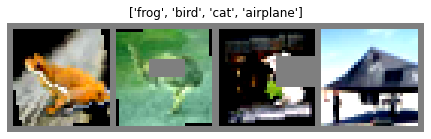

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


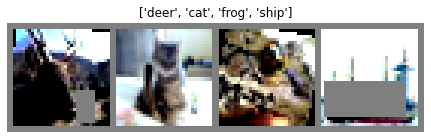

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


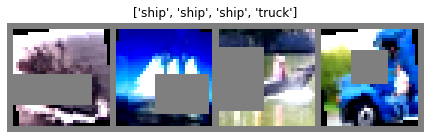

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


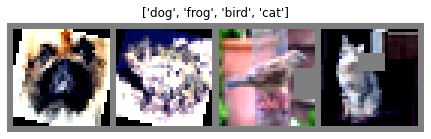

In [9]:
for i in range(4):
    show_batch_images(trainloader)

## Custom Model Architecture

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=48, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(48),   
            nn.ReLU()
         
        ) # output_size = [N , 48 , 32 , 32]

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=48, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(48),   
            nn.ReLU()
         
        ) # output_size = [N , 48 , 30 , 30]

        # pooling layer
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = [N , 48 , 15 , 15]

        self.convblock3 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Conv2d(in_channels=48, out_channels=96, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(96), 
            nn.ReLU()
        ) # output_size = [N , 96 , 15 , 15]

        self.convblock4 = nn.Sequential(
            #nn.Dropout(0.25),
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(96), 
            nn.ReLU()
        ) # output_size = [N , 96 , 13 , 13]

        # pooling layer
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = [N , 96 , 6 , 6]

        self.convblock5 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Conv2d(in_channels=96, out_channels=192, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU()
        ) # output_size = [N , 192 , 6 , 6]

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.Dropout(0.25)
        ) # output_size = [N , 192 , 4 , 4]

        self.fc_model = nn.Sequential(
            nn.Linear(3072*2,512),         # (N, 3072*2) -> (N, 512)
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512,512),             # (N, 512) -> (N, 512)
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512,256),          # (N, 512) -> (N, 256)
            nn.Linear(256,10)            # (N, 256)  -> (N, 10)
        )
      

    def forward(self, x):
        img = copy.deepcopy(x)
               
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)

        
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool2(x)

        x = self.convblock5(x)
        x = self.convblock6(x)
        x = x.view(x.size(0), -1) # (N, 16, 5, 5) -> (N, 400)
        
        #Skip connection feeding input image directly into Fully connected layers
        x = torch.cat((x,img.reshape(x.size(0),-1)),dim = 1)
        
        x = self.fc_model(x)

        return F.log_softmax(x, dim=-1)


In [11]:
from torchsummary import summary
net = Net().to(device)
print(summary(net, (3, 32, 32)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,296
       BatchNorm2d-2           [-1, 48, 32, 32]              96
              ReLU-3           [-1, 48, 32, 32]               0
            Conv2d-4           [-1, 48, 30, 30]          20,736
       BatchNorm2d-5           [-1, 48, 30, 30]              96
              ReLU-6           [-1, 48, 30, 30]               0
         MaxPool2d-7           [-1, 48, 15, 15]               0
           Dropout-8           [-1, 48, 15, 15]               0
            Conv2d-9           [-1, 96, 15, 15]          41,472
      BatchNorm2d-10           [-1, 96, 15, 15]             192
             ReLU-11           [-1, 96, 15, 15]               0
           Conv2d-12           [-1, 96, 13, 13]          82,944
      BatchNorm2d-13           [-1, 96, 13, 13]             192
             ReLU-14           [-1, 96,

## Train CIFAR10 (CNN + MLP)

In [12]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [13]:
def evaluation(dataloader,model):
  total , correct = 0,0
  for data in dataloader:
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total


In [14]:
# Initialise and move model to Cuda
net = Net().to(device)

#this takes into consideration that we have to differentiate through softmax layer, given softmax is not applied in our vgg
loss_fn = nn.CrossEntropyLoss() 
opt = optim.SGD(net.parameters(), lr=0.01,momentum = 0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=len(trainloader)*10, gamma=0.01)


In [15]:
# Training Loop

loss_epoch_arr_CNN_MLP = []
max_epochs = 150
train_acc_CNN_MLP = []
val_acc_CNN_MLP = []

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        #scheduler.step()
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr_CNN_MLP.append(loss.item())
    train_acc_CNN_MLP.append(evaluation(trainloader, net))
    val_acc_CNN_MLP.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))

Iteration: 0/782, Loss: 2.31
Iteration: 500/782, Loss: 1.28
Epoch: 1/150, Test acc: 53.38, Train acc: 51.12
Iteration: 0/782, Loss: 1.28
Iteration: 500/782, Loss: 1.03
Epoch: 2/150, Test acc: 63.01, Train acc: 60.66
Iteration: 0/782, Loss: 1.41
Iteration: 500/782, Loss: 0.99
Epoch: 3/150, Test acc: 65.81, Train acc: 62.98
Iteration: 0/782, Loss: 1.13
Iteration: 500/782, Loss: 0.76
Epoch: 4/150, Test acc: 70.14, Train acc: 66.98
Iteration: 0/782, Loss: 1.12
Iteration: 500/782, Loss: 0.92
Epoch: 5/150, Test acc: 71.41, Train acc: 68.89
Iteration: 0/782, Loss: 0.88
Iteration: 500/782, Loss: 1.02
Epoch: 6/150, Test acc: 73.66, Train acc: 70.91
Iteration: 0/782, Loss: 0.65
Iteration: 500/782, Loss: 0.59
Epoch: 7/150, Test acc: 74.51, Train acc: 71.63
Iteration: 0/782, Loss: 0.75
Iteration: 500/782, Loss: 0.85
Epoch: 8/150, Test acc: 76.13, Train acc: 73.53
Iteration: 0/782, Loss: 0.96
Iteration: 500/782, Loss: 0.56
Epoch: 9/150, Test acc: 76.72, Train acc: 73.75
Iteration: 0/782, Loss: 0.59

## Training Last 10 epochs without Random Eraser

In [16]:
transform_train = transforms.Compose([
    transforms.RandomRotation((-14.0, 14.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.4913997551666284, 0.48215855929893703, 0.4465309133731618), (0.24703225141799082, 0.24348516474564, 0.26158783926049628)),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4913997551666284, 0.48215855929893703, 0.4465309133731618), (0.24703225141799082, 0.24348516474564, 0.26158783926049628)),
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)


trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle = True)


Files already downloaded and verified
Files already downloaded and verified


In [17]:
max_epochs = 10

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        #scheduler.step()
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr_CNN_MLP.append(loss.item())
    train_acc_CNN_MLP.append(evaluation(trainloader, net))
    val_acc_CNN_MLP.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))


Iteration: 0/782, Loss: 0.18
Iteration: 500/782, Loss: 0.06
Epoch: 1/10, Test acc: 85.01, Train acc: 97.57
Iteration: 0/782, Loss: 0.03
Iteration: 500/782, Loss: 0.04
Epoch: 2/10, Test acc: 84.82, Train acc: 97.74
Iteration: 0/782, Loss: 0.03
Iteration: 500/782, Loss: 0.21
Epoch: 3/10, Test acc: 84.93, Train acc: 97.52
Iteration: 0/782, Loss: 0.25
Iteration: 500/782, Loss: 0.08
Epoch: 4/10, Test acc: 84.37, Train acc: 97.57
Iteration: 0/782, Loss: 0.11
Iteration: 500/782, Loss: 0.16
Epoch: 5/10, Test acc: 84.63, Train acc: 97.68
Iteration: 0/782, Loss: 0.02
Iteration: 500/782, Loss: 0.10
Epoch: 6/10, Test acc: 85.08, Train acc: 97.82
Iteration: 0/782, Loss: 0.01
Iteration: 500/782, Loss: 0.02
Epoch: 7/10, Test acc: 84.32, Train acc: 97.76
Iteration: 0/782, Loss: 0.00
Iteration: 500/782, Loss: 0.06
Epoch: 8/10, Test acc: 84.70, Train acc: 97.60
Iteration: 0/782, Loss: 0.05
Iteration: 500/782, Loss: 0.04
Epoch: 9/10, Test acc: 84.97, Train acc: 97.86
Iteration: 0/782, Loss: 0.01
Iteratio

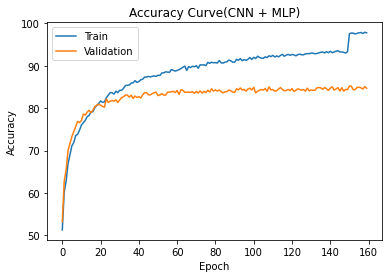

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_acc_CNN_MLP,label='Train')
ax.plot(val_acc_CNN_MLP, label='Validation')

plt.title("Accuracy Curve(CNN + MLP)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

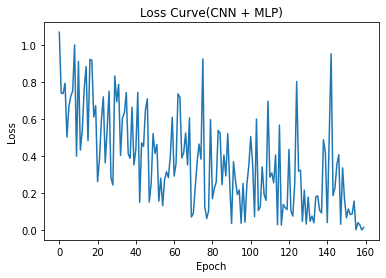

In [19]:
plt.plot(loss_epoch_arr_CNN_MLP)
plt.title("Loss Curve(CNN + MLP)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

#Testing Model on a random image

In [23]:
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle=True)
for data in testloader:
  image , label = data
  break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


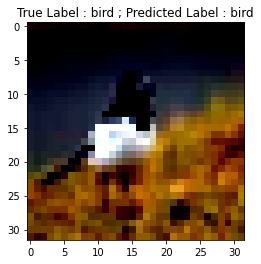

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


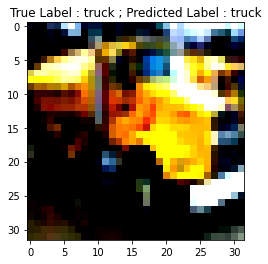

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


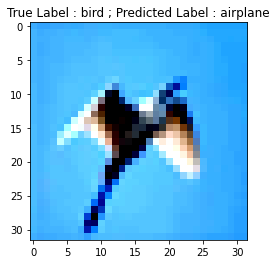

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


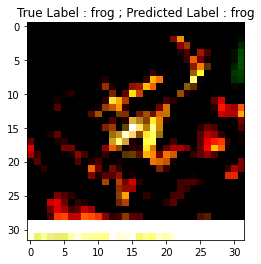

In [24]:
net = net.to('cpu')
for img , label in zip(image , label):
  _,prediction = torch.max(net(img.unsqueeze(0)).data,1)
  plt.imshow(img.permute(1,2,0))
  plt.title(f"True Label : {trainset.classes[label.item()]} ; Predicted Label : {trainset.classes[prediction]}")
  plt.show()

## Train CIFAR10 (MLP)

In [3]:
import tensorflow as tf
from sklearn.decomposition import PCA
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.cifar10.load_data()
x_train = x_train.reshape(50000, 32*32*3)
x_test = x_test.reshape(10000, 32*32*3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [4]:
#pca = PCA()
pca_result = x_train

In [5]:
PCA_train = x_train
PCA_test = x_test

In [6]:
PCA_train = torch.FloatTensor(PCA_train)
PCA_test = torch.FloatTensor(PCA_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [7]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(PCA_train,y_train) # create your datset
test_dataset = TensorDataset(PCA_test,y_test) # create your datset
trainloader = DataLoader(train_dataset,batch_size= 64) # create your dataloader
testloader = DataLoader(test_dataset,batch_size= 64) # create your dataloader

In [10]:
class ANN(nn.Module):
  def __init__(self):
      super().__init__()
      self.fc_model = nn.Sequential(
          nn.Linear(3072,512),         # (N, 3072*2) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,512),             # (N, 512) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,256),          # (N, 512) -> (N, 256)
          nn.Linear(256,10)            # (N, 256)  -> (N, 10)
      )
      
  def forward(self, x):
      x = self.fc_model(x)
      return x

In [11]:
net = ANN().to(device)
net

ANN(
  (fc_model): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
from torchsummary import summary
print(summary(net, (1,3072)))


In [ ]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr=0.01)

In [ ]:
def evaluation(dataloader,model):
  total , correct = 0,0
  for data in dataloader:
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    # print("pred",pred )
    # print("labels",labels.squeeze(1))
    correct += (pred == labels.squeeze(1)).sum().item()
  return 100 * correct / total


In [ ]:
# Training Loop

loss_epoch_arr_MLP = []
max_epochs = 150
train_acc_MLP = []
val_acc_MLP = []

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)

        loss = loss_fn(outputs, labels.squeeze(1))
        loss.backward()
        opt.step()

        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr_MLP.append(loss.item())
    train_acc_MLP.append(evaluation(trainloader, net))
    val_acc_MLP.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_acc_MLP,label='Train')
ax.plot(val_acc_MLP, label='Validation')

plt.title("Accuracy Curves (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

In [ ]:
plt.plot(loss_epoch_arr_MLP)
plt.title("Loss Curve (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Train CIFAR10 PCA (90 % Variance ) + MLP

In [ ]:
import tensorflow as tf
from sklearn.decomposition import PCA
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.cifar10.load_data()
x_train = x_train.reshape(50000, 32*32*3)
x_test = x_test.reshape(10000, 32*32*3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [ ]:
pca = PCA(0.9)
pca_result = pca.fit(x_train)

In [ ]:
pca.n_components_

In [ ]:
PCA_train = pca.transform(x_train)
PCA_test = pca.transform(x_test)

In [ ]:
PCA_train = torch.FloatTensor(PCA_train)
PCA_test = torch.FloatTensor(PCA_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(PCA_train,y_train) # create your datset
test_dataset = TensorDataset(PCA_test,y_test) # create your datset
trainloader = DataLoader(train_dataset,batch_size= 64) # create your dataloader
testloader = DataLoader(test_dataset,batch_size= 64) # create your dataloader

In [ ]:
class ANN(nn.Module):
  def __init__(self):
      super().__init__()
      self.fc_model = nn.Sequential(
          nn.Linear(pca.n_components_,512),         # (N, 3072*2) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,512),             # (N, 512) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,256),          # (N, 512) -> (N, 256)
          nn.Linear(256,10)            # (N, 256)  -> (N, 10)
      )
      
  def forward(self, x):
      x = self.fc_model(x)
      return x

In [ ]:
net = ANN().to(device)
net

In [ ]:
from torchsummary import summary
print(summary(net, (1,pca.n_components_)))


In [ ]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr=0.01)

In [ ]:
def evaluation(dataloader,model):
  total , correct = 0,0
  for data in dataloader:
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    # print("pred",pred )
    # print("labels",labels.squeeze(1))
    correct += (pred == labels.squeeze(1)).sum().item()
  return 100 * correct / total


In [ ]:
# Training Loop

loss_epoch_arr_PCA_90_MLP = []
max_epochs = 150
train_acc_PCA_90_MLP = []
val_acc_PCA_90_MLP = []

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)

        loss = loss_fn(outputs, labels.squeeze(1))
        loss.backward()
        opt.step()

        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr_PCA_90_MLP.append(loss.item())
    train_acc_PCA_90_MLP.append(evaluation(trainloader, net))
    val_acc_PCA_90_MLP.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_acc_PCA_90_MLP,label='Train')
ax.plot(val_acc_PCA_90_MLP, label='Validation')

plt.title("Accuracy Curves (PCA (90% variance) +MLP)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

In [ ]:
plt.plot(loss_epoch_arr_PCA_90_MLP)
plt.title("Loss Curve(PCA (90% variance) +MLP)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Train CIFAR10 PCA (95 % Variance ) + MLP

In [ ]:
import tensorflow as tf
from sklearn.decomposition import PCA
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.cifar10.load_data()
x_train = x_train.reshape(50000, 32*32*3)
x_test = x_test.reshape(10000, 32*32*3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [ ]:
pca = PCA(0.95)
pca_result = pca.fit(x_train)

In [ ]:
pca.n_components_

In [ ]:
PCA_train = pca.transform(x_train)
PCA_test = pca.transform(x_test)

In [ ]:
PCA_train = torch.FloatTensor(PCA_train)
PCA_test = torch.FloatTensor(PCA_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(PCA_train,y_train) # create your datset
test_dataset = TensorDataset(PCA_test,y_test) # create your datset
trainloader = DataLoader(train_dataset,batch_size= 64) # create your dataloader
testloader = DataLoader(test_dataset,batch_size= 64) # create your dataloader

In [ ]:
class ANN(nn.Module):
  def __init__(self):
      super().__init__()
      self.fc_model = nn.Sequential(
          nn.Linear(pca.n_components_,512),         # (N, 3072*2) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,512),             # (N, 512) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,256),          # (N, 512) -> (N, 256)
          nn.Linear(256,10)            # (N, 256)  -> (N, 10)
      )
      
  def forward(self, x):
      x = self.fc_model(x)
      return x

In [ ]:
net = ANN().to(device)
net

In [ ]:
from torchsummary import summary
print(summary(net, (1,pca.n_components_)))


In [ ]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr=0.01)

In [ ]:
def evaluation(dataloader,model):
  total , correct = 0,0
  for data in dataloader:
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    # print("pred",pred )
    # print("labels",labels.squeeze(1))
    correct += (pred == labels.squeeze(1)).sum().item()
  return 100 * correct / total


In [ ]:
# Training Loop

loss_epoch_arr_PCA_95_MLP = []
max_epochs = 150
train_acc_PCA_95_MLP = []
val_acc_PCA_95_MLP = []

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)

        loss = loss_fn(outputs, labels.squeeze(1))
        loss.backward()
        opt.step()

        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr_PCA_95_MLP.append(loss.item())
    train_acc_PCA_95_MLP.append(evaluation(trainloader, net))
    val_acc_PCA_95_MLP.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_acc_PCA_95_MLP,label='Train')
ax.plot(val_acc_PCA_95_MLP, label='Validation')

plt.title("Accuracy Curves(PCA (95% variance) +MLP)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

In [ ]:
plt.plot(loss_epoch_arr_PCA_95_MLP)
plt.title("Loss Curve(PCA (95% variance) +MLP)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Train CIFAR10  PCA (99 % Variance) + MLP

In [ ]:
import tensorflow as tf
from sklearn.decomposition import PCA
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.cifar10.load_data()
x_train = x_train.reshape(50000, 32*32*3)
x_test = x_test.reshape(10000, 32*32*3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [ ]:
pca = PCA(0.99)
pca_result = pca.fit(x_train)

In [ ]:
pca.n_components_

In [ ]:
PCA_train = pca.transform(x_train)
PCA_test = pca.transform(x_test)

In [ ]:
PCA_train = torch.FloatTensor(PCA_train)
PCA_test = torch.FloatTensor(PCA_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(PCA_train,y_train) # create your datset
test_dataset = TensorDataset(PCA_test,y_test) # create your datset
trainloader = DataLoader(train_dataset,batch_size= 64) # create your dataloader
testloader = DataLoader(test_dataset,batch_size= 64) # create your dataloader

In [ ]:
class ANN(nn.Module):
  def __init__(self):
      super().__init__()
      self.fc_model = nn.Sequential(
          nn.Linear(pca.n_components_,512),         # (N, 3072*2) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,512),             # (N, 512) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,256),          # (N, 512) -> (N, 256)
          nn.Linear(256,10)            # (N, 256)  -> (N, 10)
      )
      
  def forward(self, x):
      x = self.fc_model(x)
      return x

In [ ]:
net = ANN().to(device)
net

In [ ]:
from torchsummary import summary
print(summary(net, (1,pca.n_components_)))


In [ ]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr=0.01)

In [ ]:
def evaluation(dataloader,model):
  total , correct = 0,0
  for data in dataloader:
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    # print("pred",pred )
    # print("labels",labels.squeeze(1))
    correct += (pred == labels.squeeze(1)).sum().item()
  return 100 * correct / total


In [ ]:
# Training Loop

loss_epoch_arr_PCA_99_MLP = []
max_epochs = 150
train_acc_PCA_99_MLP = []
val_acc_PCA_99_MLP = []

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)

        loss = loss_fn(outputs, labels.squeeze(1))
        loss.backward()
        opt.step()

        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr_PCA_99_MLP.append(loss.item())
    train_acc_PCA_99_MLP.append(evaluation(trainloader, net))
    val_acc_PCA_99_MLP.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_acc_PCA_99_MLP,label='Train')
ax.plot(val_acc_PCA_99_MLP, label='Validation')

plt.title("Accuracy Curves(PCA (99% variance) +MLP)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

In [ ]:
plt.plot(loss_epoch_arr_PCA_99_MLP)
plt.title("Loss Curve(PCA (99% variance) +MLP)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Train Accuracy PLot

In [ ]:
fig, ax = plt.subplots()

ax.plot(train_acc_MLP,label='MLP')
ax.plot(train_acc_CNN_MLP,label='CNN + MLP')
ax.plot(train_acc_PCA_90_MLP, label='PCA(90% Variance) + MLP')
ax.plot(train_acc_PCA_95_MLP,label='PCA(95% Variance) + MLP')
ax.plot(train_acc_PCA_99_MLP, label='PCA(99% Variance) + MLP')

plt.title("Train Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

## Test Accuracy Plot

In [ ]:
fig, ax = plt.subplots()

ax.plot(val_acc_MLP,label='MLP')
ax.plot(val_acc_CNN_MLP,label='CNN + MLP')
ax.plot(val_acc_PCA_90_MLP, label='PCA(90% Variance) + MLP')
ax.plot(val_acc_PCA_95_MLP,label='PCA(95% Variance) + MLP')
ax.plot(val_acc_PCA_99_MLP, label='PCA(99% Variance) + MLP')

plt.title("Validation Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

## Loss Curves

In [ ]:
fig, ax = plt.subplots()

ax.plot(loss_epoch_arr_MLP,label='MLP')
ax.plot(loss_epoch_arr_CNN_MLP,label='CNN + MLP')
ax.plot(loss_epoch_arr_PCA_90_MLP, label='PCA(90% Variance) + MLP')
ax.plot(loss_epoch_arr_PCA_95_MLP,label='PCA(95% Variance) + MLP')
ax.plot(loss_epoch_arr_PCA_99_MLP, label='PCA(99% Variance) + MLP')

plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

In [44]:
loss_epoch_arr_CNN_MLP

[1.070456862449646,
 0.7419290542602539,
 0.7385035157203674,
 0.7942847013473511,
 0.5035861134529114,
 0.6688485145568848,
 0.7241373658180237,
 0.7524973750114441,
 1.0022330284118652,
 0.40014520287513733,
 0.9127349257469177,
 0.4331335723400116,
 0.5404263734817505,
 0.762119472026825,
 0.8849634528160095,
 0.4833984375,
 0.9234429001808167,
 0.9191961288452148,
 0.611676037311554,
 0.6730920076370239,
 0.26282501220703125,
 0.3838680386543274,
 0.5958355069160461,
 0.7211748361587524,
 0.36370712518692017,
 0.5461297631263733,
 0.751544713973999,
 0.28278735280036926,
 0.24394488334655762,
 0.8334401249885559,
 0.6953400373458862,
 0.7887815237045288,
 0.40382903814315796,
 0.6075870394706726,
 0.6338983774185181,
 0.7441968321800232,
 0.4126707911491394,
 0.3884553015232086,
 0.6645413041114807,
 0.35225820541381836,
 0.43665575981140137,
 0.7450542449951172,
 0.1501682549715042,
 0.47193944454193115,
 0.4530881941318512,
 0.6506341695785522,
 0.7104873061180115,
 0.15167720615

In [45]:
train_acc_CNN_MLP


[51.308,
 60.246,
 62.766,
 66.882,
 68.97,
 71.126,
 71.878,
 73.562,
 73.826,
 74.824,
 76.0,
 76.588,
 77.136,
 77.99,
 78.276,
 79.13,
 79.138,
 80.15,
 80.594,
 81.088,
 81.684,
 81.384,
 81.46,
 82.434,
 83.04,
 83.654,
 83.628,
 83.308,
 84.004,
 83.65,
 84.204,
 84.21,
 84.68,
 85.324,
 85.386,
 85.444,
 85.914,
 85.972,
 86.474,
 86.06,
 86.264,
 86.688,
 86.806,
 87.324,
 87.318,
 87.47,
 87.366,
 87.482,
 87.608,
 87.468,
 87.764,
 87.694,
 88.282,
 88.324,
 88.55,
 88.504,
 88.436,
 89.1,
 88.898,
 88.732,
 88.882,
 89.08,
 89.328,
 89.618,
 89.912,
 88.884,
 89.788,
 89.548,
 89.874,
 89.724,
 90.012,
 89.382,
 90.206,
 90.166,
 90.206,
 90.02,
 90.774,
 90.554,
 90.82,
 90.68,
 90.72,
 90.616,
 91.212,
 90.668,
 90.616,
 90.832,
 90.916,
 91.32,
 91.15,
 90.846,
 90.806,
 91.498,
 91.27,
 91.678,
 91.172,
 91.452,
 91.266,
 91.504,
 91.932,
 91.468,
 91.976,
 91.666,
 92.228,
 91.966,
 91.774,
 91.722,
 92.09,
 91.91,
 92.336,
 92.138,
 92.438,
 92.052,
 92.31,
 92.084,
 

In [46]:
val_acc_CNN_MLP 

[53.21,
 62.75,
 65.47,
 70.04,
 71.61,
 73.27,
 74.43,
 75.66,
 76.86,
 76.59,
 77.11,
 78.58,
 78.37,
 79.06,
 79.49,
 78.92,
 79.53,
 80.33,
 80.71,
 80.9,
 80.7,
 80.4,
 80.22,
 82.13,
 81.35,
 81.61,
 81.8,
 81.64,
 81.96,
 81.34,
 81.94,
 82.5,
 82.66,
 83.11,
 83.06,
 82.6,
 83.04,
 82.29,
 82.85,
 82.51,
 82.7,
 82.37,
 83.14,
 83.65,
 83.66,
 83.12,
 83.13,
 83.41,
 83.64,
 83.76,
 82.95,
 83.1,
 83.43,
 83.06,
 83.08,
 83.77,
 83.76,
 83.87,
 83.97,
 83.66,
 84.16,
 83.23,
 84.31,
 84.21,
 83.71,
 83.78,
 83.74,
 83.72,
 83.89,
 83.5,
 83.93,
 83.57,
 84.05,
 83.56,
 83.96,
 83.68,
 84.2,
 83.79,
 84.55,
 84.02,
 84.28,
 84.02,
 84.26,
 83.89,
 83.6,
 83.86,
 83.89,
 84.27,
 84.07,
 83.81,
 83.69,
 84.55,
 84.33,
 84.76,
 84.27,
 84.41,
 84.01,
 84.51,
 84.69,
 84.29,
 84.89,
 83.6,
 83.98,
 84.21,
 84.38,
 84.25,
 84.62,
 83.98,
 85.0,
 84.32,
 84.37,
 83.98,
 84.1,
 84.52,
 84.85,
 84.39,
 84.09,
 84.18,
 84.4,
 84.13,
 84.6,
 83.93,
 84.2,
 84.54,
 84.42,
 84.23,
 84.38,
 